In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from utils import *
from plotting import *
import json

MAX_K = 100
TARGET_MODE = "morph"
RUNDIR = "/home/mila/s/stephen.lu/scratch/gfn_gene/wandb_sweeps"
SAVEDIR = "/home/mila/s/stephen.lu/scratch/trash"

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with transformers dependency. No module named 'transformers'
cannot import name 'HuggingFaceModel' from 'deepchem.models.torch_models' (/home/mila/s/stephen.lu/miniconda3/envs/gfn/lib/python3.10/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'
Skipped loading some PyTorch models, missing a dependency. No module named 'tensorflow'


cuda


In [3]:
# Get full PUMA dataset latents, fingerprints, and smiles
datamodule, cfg = setup_puma()
representations = get_representations()
dataset_smis = np.array([x["inputs"]["struct"].mols for x in datamodule.dataset])
dataset_fps = load_puma_dataset_fps(dataset_smis, save_fps=True)

# Load models and ground truth data
assay_dataset = load_assay_matrix_from_csv()
assay_model = load_assay_pred_model().to(device)
cluster_labels = load_cluster_labels_from_csv()
cluster_model = load_cluster_pred_model().to(device)
mmc_model = load_mmc_model(cfg).to(device)

# Run inference on PUMA test split
_, _, test_idx = datamodule.get_split_idx()
puma_test_assay_preds = predict_assay_logits_from_smi(None, dataset_smis[test_idx], assay_model, None, save_preds=False)
puma_test_cluster_preds = predict_cluster_logits_from_smi(None, dataset_smis[test_idx], cluster_model, None, save_preds=False, use_gneprop=False)

shuffled_scaffold


Train on samples from shuffled_scaffold.
Train on 13568 samples.
Validate on 1696 samples.
Test on 1697 samples.


INFO:root:Instantiating torch.nn.module JointEncoder
INFO:root:Instantiating lightning model <multimodal_contrastive.networks.models.GMC_PL>
100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


In [4]:
run = {
    "target_idx": 903,
    "reward_thresh": 0.95,
    "run_paths": {
        "GFN(t=1)": "04-30-05-48-morph-sim-run-lower-temp/driven-sweep-2-id-721585y2",
        # "GFN(t=32)": "04-30-03-06-morph-sim-run-with-dataset/stoic-sweep-2-id-4kd1wvak",
        # "GFN(t=64)": "05-06-06-21-morph-sim-903-high-temp/solar-sweep-1-id-7mlasa01",
        # "GFN(t=128)": "05-06-06-24-morph-sim-903-high-temp/tough-sweep-2-id-2ao10i82",
        # "RND": "04-30-01-59-morph-sim-run-random-baselines/devoted-sweep-2-id-lipfnja5"
    },
    "bs": {
        "GFN(t=1)": 64,
        "GFN(t=32)": 64,
        "GFN(t=64)": 64,
        "GFN(t=128)": 64,
        "RND": 64
    }
}

In [5]:
target_idx, run_paths, rew_thresh = run["target_idx"], run["run_paths"], run["reward_thresh"]
print(f"Producing plots for target {target_idx} under mode {TARGET_MODE}...")
target_sample_path = f"/home/mila/s/stephen.lu/gfn_gene/res/mmc/targets/sample_{target_idx}.pkl"
save_dir = f"{SAVEDIR}/{target_idx}"
os.makedirs(save_dir, exist_ok=True)

# Load target fingerprint, smiles, latents, active assay cols (if any)
target_smi, target_fp, target_struct_latent, target_morph_latent, target_joint_latent, target_reward =\
    load_target_from_path(target_sample_path, mmc_model, target_mode=TARGET_MODE)
target_active_assay_cols = get_active_assay_cols(assay_dataset, target_smi)
target_cluster_id = cluster_labels.loc[target_smi]["Activity"]
target_latent = target_morph_latent if TARGET_MODE == "morph" else target_joint_latent
print(target_active_assay_cols, target_cluster_id)

# Infer target & dataset reward, target assay logits, and target cluster logits
target_reward = cosine_similarity(target_struct_latent, target_latent)[0][0]
dataset_rewards = ((cosine_similarity(representations['struct'], target_latent) + 1) / 2).reshape(-1,)
dataset_sim_to_target = np.array(AllChem.DataStructs.BulkTanimotoSimilarity(target_fp, dataset_fps))
target_assay_preds = predict_assay_logits_from_smi(None, [target_smi], assay_model, target_active_assay_cols, save_preds=False)
target_active_cluster_pred = predict_cluster_logits_from_smi(None, [target_smi], cluster_model, target_cluster_id, save_preds=False, use_gneprop=False)

print(f"Target struct~{TARGET_MODE} alignment: ", target_reward)
print(f"Target assay predicted logits: ", target_assay_preds)
print(f"Target cluster {target_cluster_id} active logit: ", target_active_cluster_pred)

# Load baseline data for runs
runs_datum = {}
for run_name, run_id in run_paths.items():
    run_path = os.path.join(RUNDIR, run_id)
    fps, rewards, smis = load_datum_from_run(RUNDIR, run_id, remove_duplicates=False)
    mols = list(map(Chem.MolFromSmiles, smis))
    tsim_to_target = np.array(AllChem.DataStructs.BulkTanimotoSimilarity(target_fp, fps))
    run_datum = {
        "path": run_path, "smis": smis, "rewards": rewards, "mols": mols,
        "fps": fps, "tsim_to_target": tsim_to_target,
    }
    runs_datum[run_name] = run_datum

# assert len(test_idx) <= MAX_K
runs_datum["PUMA_test"] = {
    "smis": dataset_smis[test_idx],
    "rewards": dataset_rewards[test_idx],
    "mols": list(map(Chem.MolFromSmiles, dataset_smis[test_idx])),
    "fps": [dataset_fps[j] for j in test_idx],
    "tsim_to_target": dataset_sim_to_target[test_idx],
}

Producing plots for target 903 under mode morph...
tensor([2]) 8


100%|██████████| 1/1 [00:00<00:00, 66.16it/s]


()


100%|██████████| 1/1 [00:00<00:00, 486.41it/s]


()
Target struct~morph alignment:  0.80913764
Target assay predicted logits:  0.9278761
Target cluster 8 active logit:  0.5761997


335251it [00:01, 268820.64it/s]

640000it [00:03, 170634.92it/s]


Loaded fps from /home/mila/s/stephen.lu/scratch/gfn_gene/wandb_sweeps/04-30-05-48-morph-sim-run-lower-temp/driven-sweep-2-id-721585y2/fps.npy!


100%|██████████| 10000/10000 [00:00<00:00, 12235.03it/s]


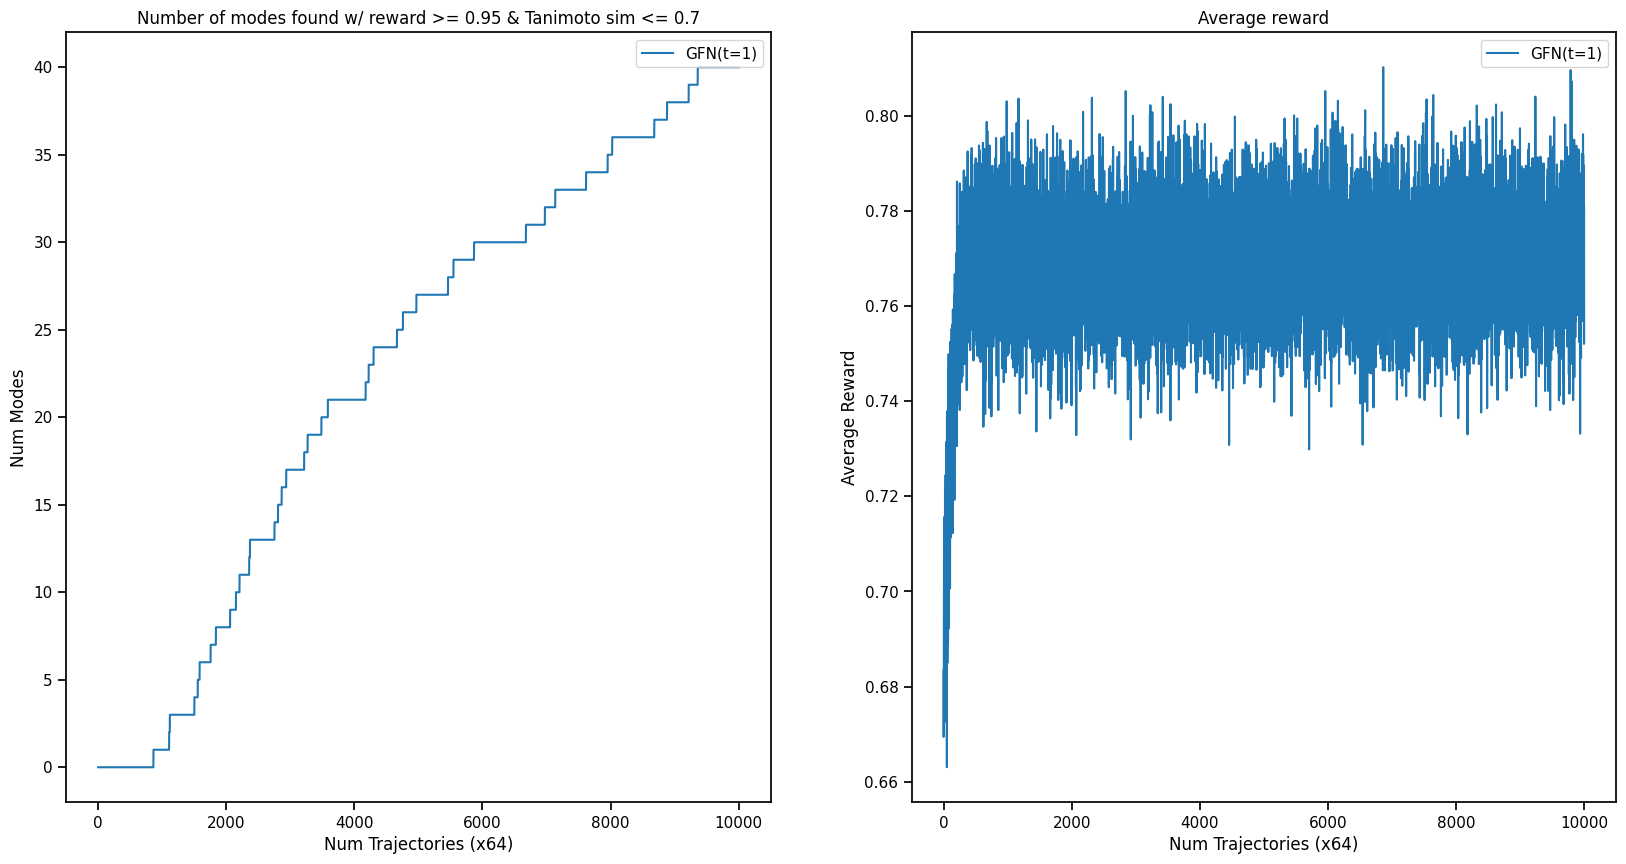

In [8]:
# PLOTS THAT REQUIRE DUPLICATES OVER THE ENTIRE TRAINING SAMPLES
plot_modes_over_trajs(runs_datum, rew_thresh=rew_thresh, sim_thresh=0.7, bs=64, ignore=["PUMA_test"], 
                        save_path=f"{save_dir}/num_modes_{rew_thresh}.png")
plt.show()

cuda


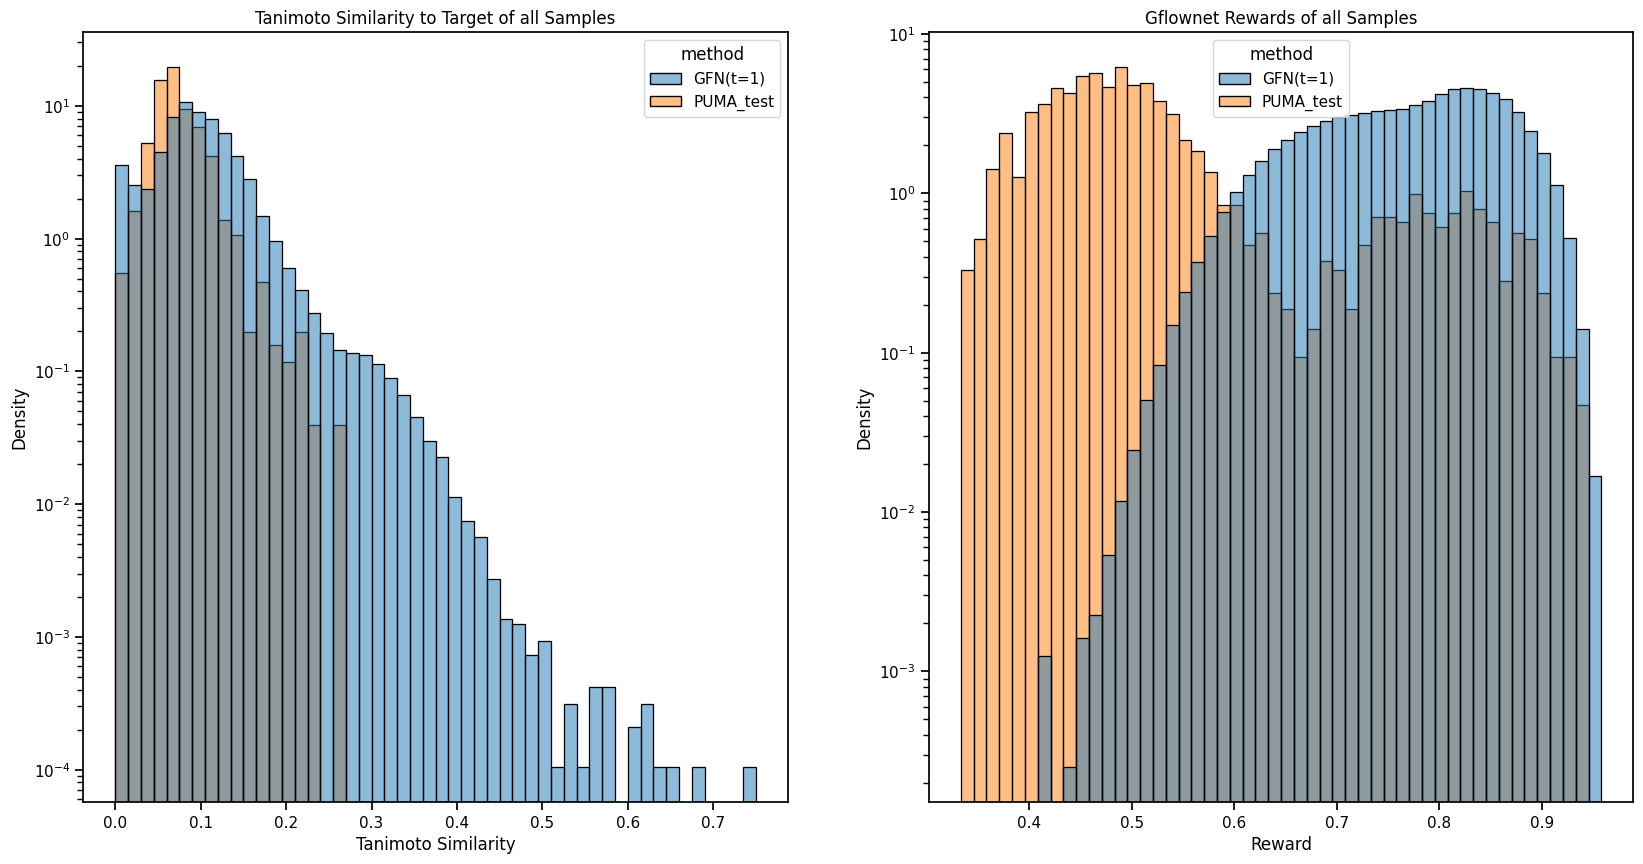

In [9]:
plot_tsim_and_reward_full_hist(runs_datum, bins=50, save_path=f"{save_dir}/tsim_and_reward_hist.png")
plt.show()

In [6]:
# Remove duplicates and compute top-k rewards, modes, and assay/cluster predictions for runs
for run_name in runs_datum.keys():
    if run_name == "PUMA_test": continue
    run_datum = remove_duplicates_from_run(runs_datum[run_name])
    rewards, smis, fps = run_datum["rewards"], run_datum["smis"], run_datum["fps"]
    top_k_reward_idx = np.argsort(rewards)[::-1][:MAX_K]
    top_k_modes_idx, top_k_modes_fps = find_modes_from_arrays(rewards, smis, fps, sim_threshold=0.7, return_fps=True)
    top_k_reward_fps = [fps[j] for j in top_k_reward_idx]
    top_k_reward_tsim_to_target = np.array(AllChem.DataStructs.BulkTanimotoSimilarity(target_fp, top_k_reward_fps))

    if not target_active_assay_cols or len(target_active_assay_cols) == 0: top_k_reward_assay_preds = []
    else: top_k_reward_assay_preds = predict_assay_logits_from_smi(run_path, smis[top_k_reward_idx], assay_model, target_active_assay_cols, force_recompute=True, save_preds=False)
    if not target_cluster_id: top_k_reward_cluster_preds = [] 
    else: top_k_reward_cluster_preds = predict_cluster_logits_from_smi(run_path, smis[top_k_reward_idx], cluster_model, target_cluster_id, force_recompute=True, save_preds=False)
    
    run_datum["top_k_reward_idx"] = top_k_reward_idx
    run_datum["top_k_reward_fps"] = top_k_reward_fps
    run_datum["top_k_reward_tsim_to_target"] = top_k_reward_tsim_to_target
    run_datum["top_k_reward_assay_preds"] = top_k_reward_assay_preds
    run_datum["top_k_reward_cluster_preds"] = top_k_reward_cluster_preds
    run_datum["top_k_modes_idx"] = top_k_modes_idx
    run_datum["top_k_modes_fps"] = top_k_modes_fps
    runs_datum[run_name] = run_datum

# Update PUMA test split with top-k rewards, modes, and assay/cluster predictions
runs_datum["PUMA_test"]["top_k_reward_idx"] = np.arange(len(test_idx))
runs_datum["PUMA_test"]["top_k_reward_fps"] = [dataset_fps[j] for j in test_idx]
runs_datum["PUMA_test"]["top_k_reward_tsim_to_target"] = dataset_sim_to_target[test_idx]
runs_datum["PUMA_test"]["top_k_reward_assay_preds"] = puma_test_assay_preds[:,target_active_assay_cols]
runs_datum["PUMA_test"]["top_k_reward_cluster_preds"] = puma_test_cluster_preds[:,target_cluster_id]
runs_datum["PUMA_test"]["top_k_modes_idx"] = np.arange(len(test_idx))
runs_datum["PUMA_test"]["top_k_modes_fps"] = [dataset_fps[j] for j in test_idx]

Removed 18173 duplicates


100%|██████████| 1/1 [00:00<00:00, 21.69it/s]


(100,)


100%|██████████| 1/1 [00:00<00:00, 22.77it/s]

(100,)


100%|██████████| 100/100 [00:00<00:00, 102902.45it/s]


[<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7fb1c69fb510>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7fb1c69dce50>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7fb1c69cef20>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7fb1c69d71f0>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7fb1c69da4d0>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7fb1c69a1fd0>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7fb1c69a3f10>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7fb1c691d760>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7fb1c681b830>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7fb1c681fab0>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7fb1c682c9f0>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7fb1c682e7f0>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7fb1c6828400>, <rdkit.DataStructs.cData

100%|██████████| 1000/1000 [00:00<00:00, 15317.07it/s]


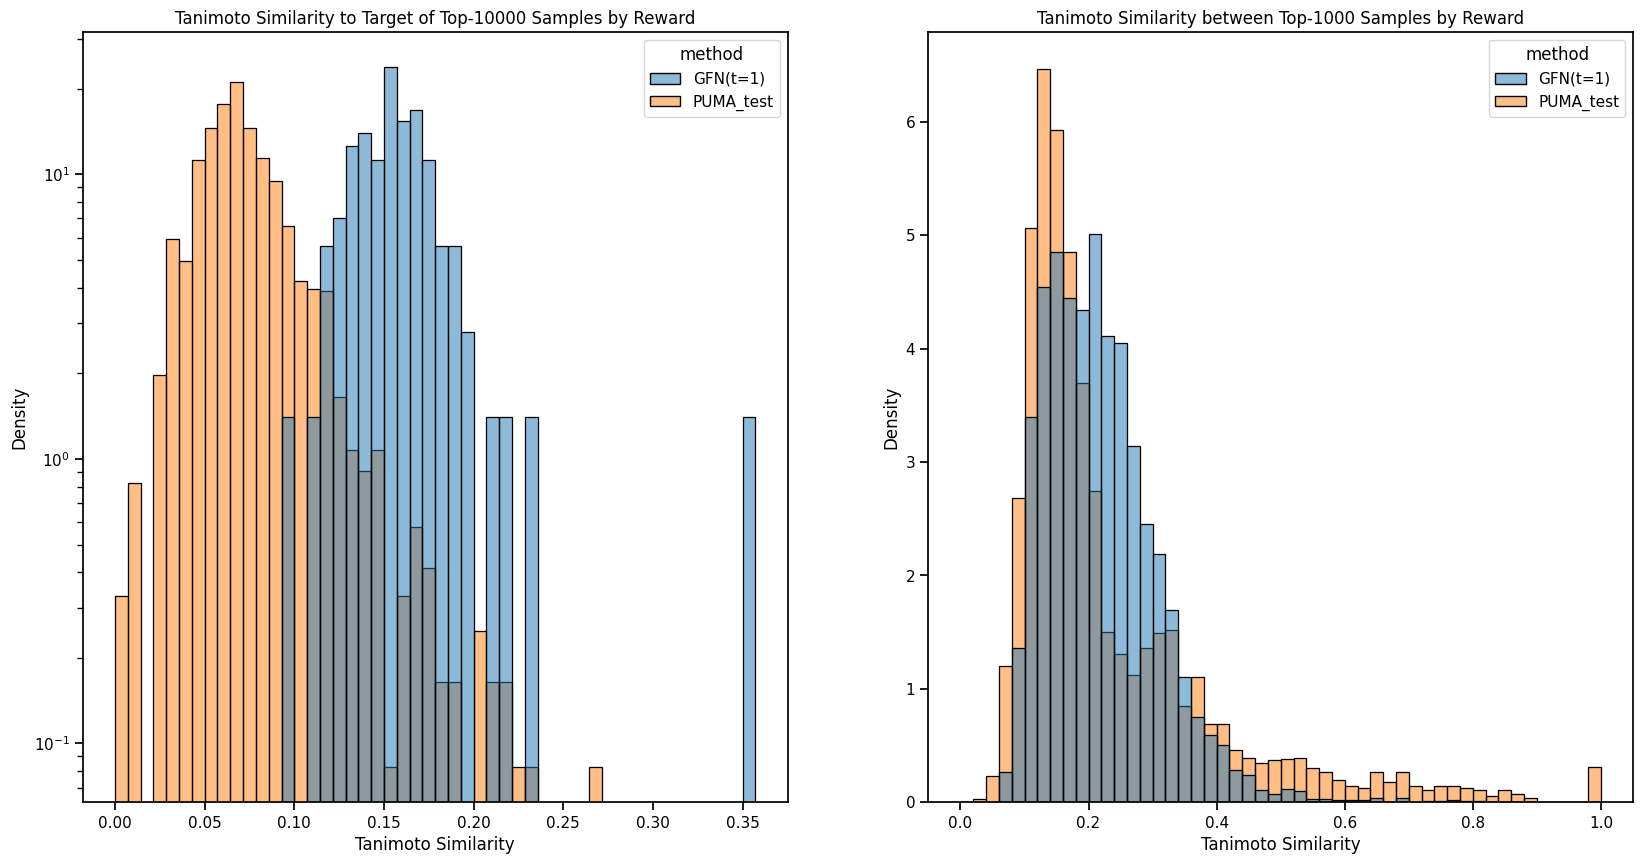

In [25]:
# PLOTS THAT REQUIRE DUPLICATES REMOVED
plot_tsim_between_modes_and_to_target(runs_datum, k1=10000, k2=1000, bins=50, 
                                        save_path=f"{save_dir}/tanimoto_sim_hist.png")
plt.show()

cuda
smis


rewards
tsim_to_target
top_k_reward_idx
top_k_reward_tsim_to_target
top_k_reward_assay_preds
top_k_reward_cluster_preds
top_k_modes_idx
Binning rewards into 15 bins between 0.33327290415763855 and 0.9582600593566895: 
Bins: [0.3332729  0.37791484 0.42255678 0.46719872 0.51184066 0.5564826
 0.60112454 0.64576648 0.69040842 0.73505036 0.7796923  0.82433424
 0.86897618 0.91361812 0.95826006]
Sampling 1000 samples per method per bin
Binning tsim_to_target into 15 bins between 0.0 and 0.75: 
Bins: [0.         0.05357143 0.10714286 0.16071429 0.21428571 0.26785714
 0.32142857 0.375      0.42857143 0.48214286 0.53571429 0.58928571
 0.64285714 0.69642857 0.75      ]
Sampling 1000 samples per method per bin


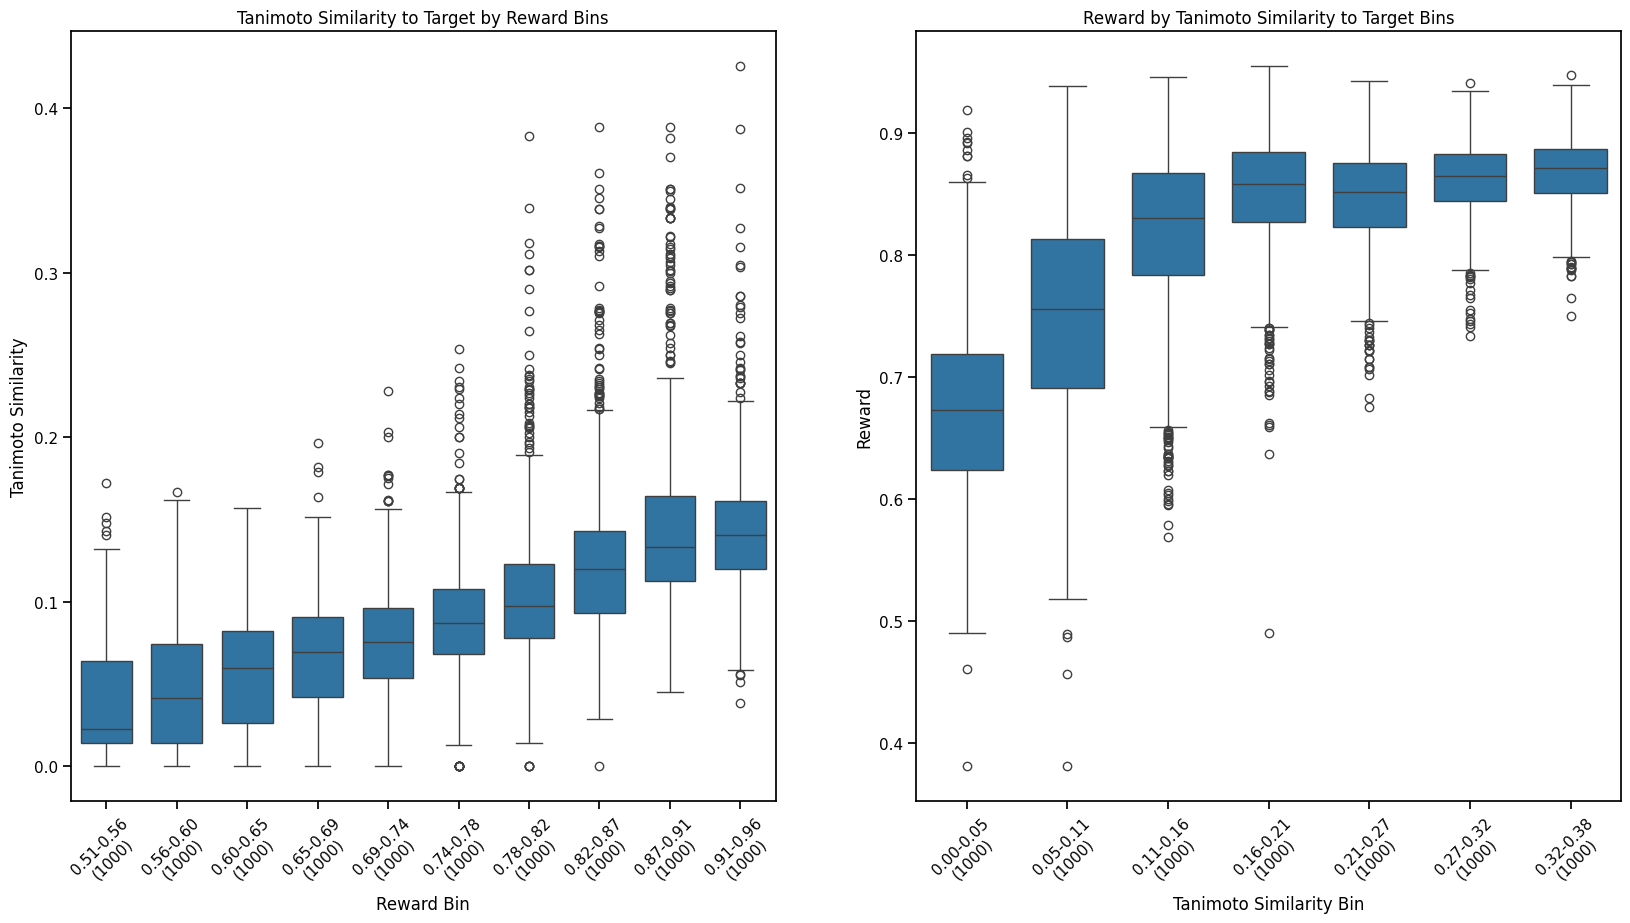

In [30]:
plot_pooled_boxplot_sim_and_rew(runs_datum, nbins1=15, nbins2=15, nsamples1=1000, nsamples2=1000,
                                save_path=f"{save_dir}/pooled_boxplot_sim_rew.png")
plt.show()

Binning rewards into 15 bins between 0.33327290415763855 and 0.9582600593566895: 
Bins: [0.3332729  0.37791484 0.42255678 0.46719872 0.51184066 0.5564826
 0.60112454 0.64576648 0.69040842 0.73505036 0.7796923  0.82433424
 0.86897618 0.91361812 0.95826006]
Sampling 1000 samples per method per bin
Binning tsim_to_target into 15 bins between 0.0 and 0.75: 
Bins: [0.         0.05357143 0.10714286 0.16071429 0.21428571 0.26785714
 0.32142857 0.375      0.42857143 0.48214286 0.53571429 0.58928571
 0.64285714 0.69642857 0.75      ]
Sampling 1000 samples per method per bin


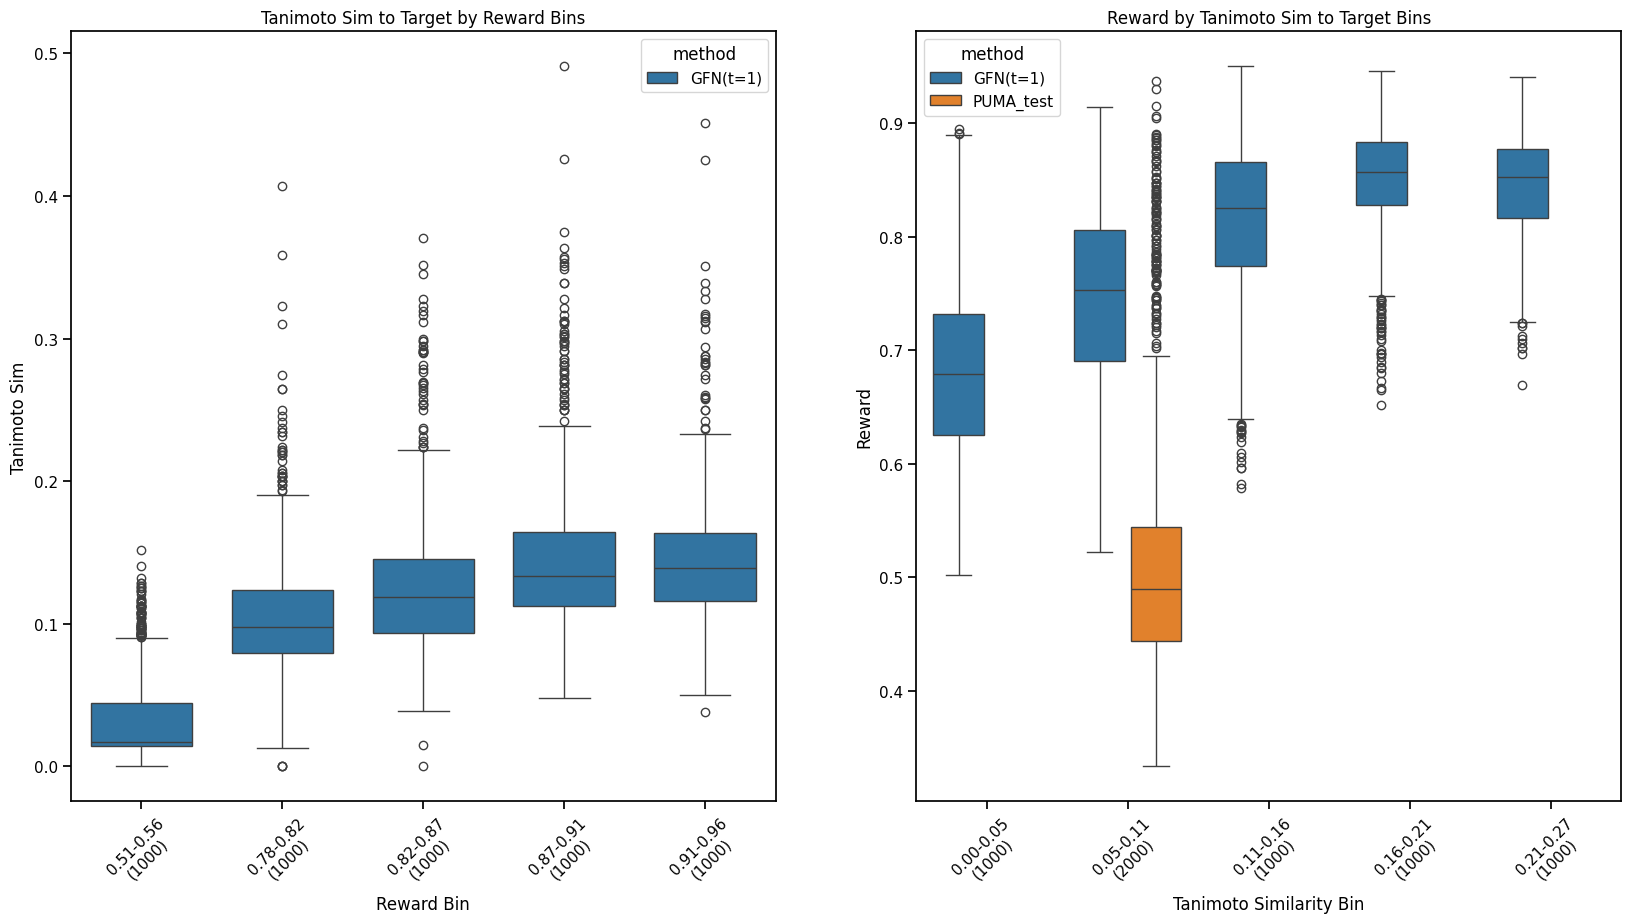

In [7]:
plot_unpooled_boxplot_sim_and_rew(runs_datum, bins1=15, bins2=15, n1=1000, n2=1000, ignore=[],
                                 save_path="unpooled_boxplot_sim_rew.png")
plt.show()

100%|██████████| 1/1 [00:00<00:00, 24.84it/s]


(100,)


100%|██████████| 1/1 [00:00<00:00, 23.90it/s]

(100,)


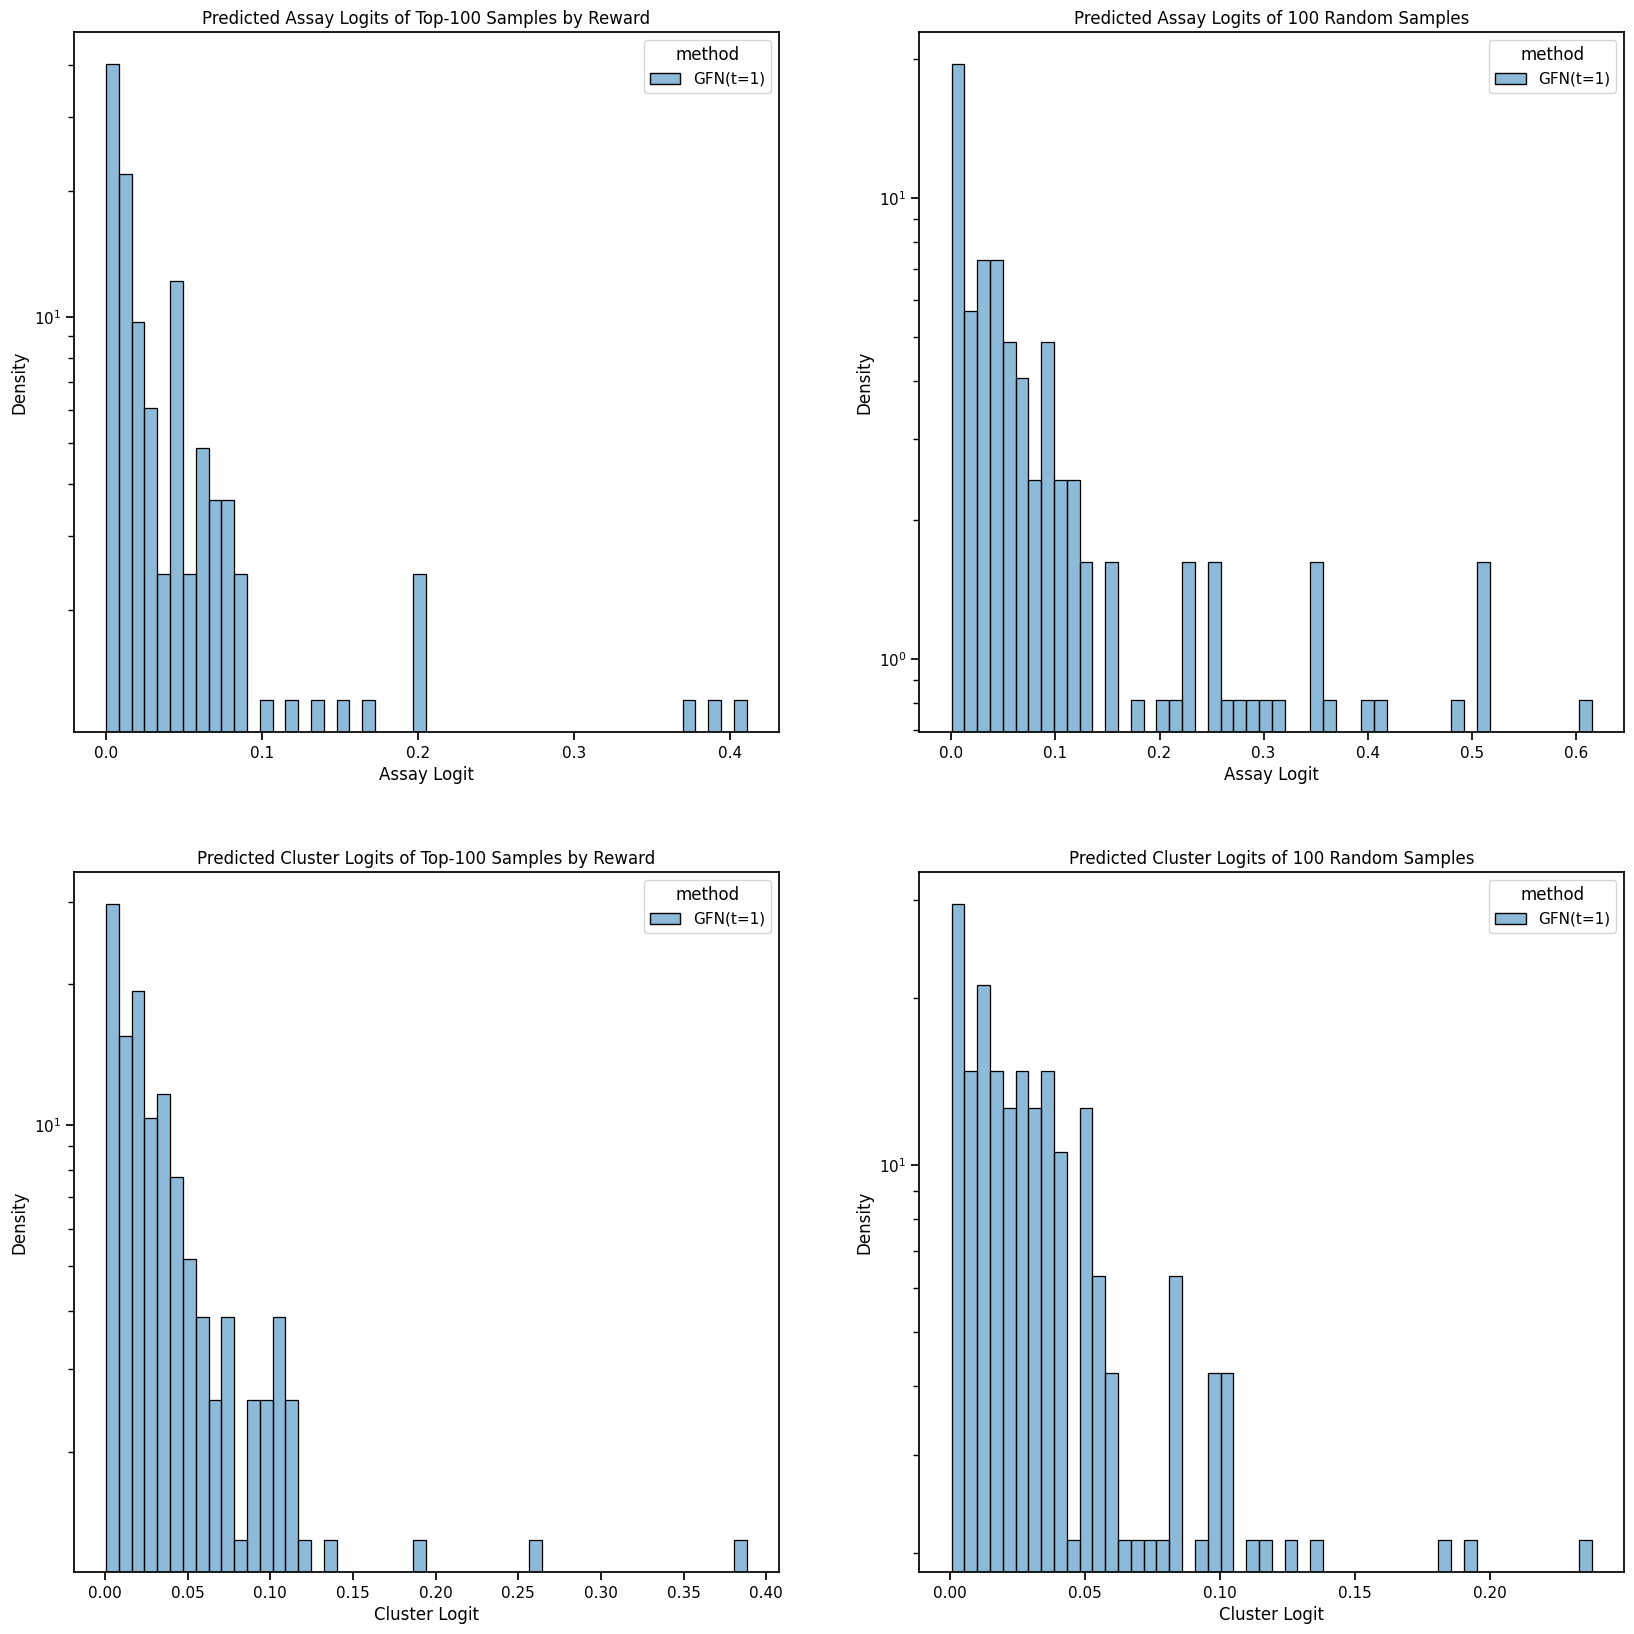

In [35]:
plot_assay_cluster_preds_hist(runs_datum, k1=MAX_K, k2=MAX_K, bins=50, assay_model=assay_model, cluster_model=cluster_model,
                                ignore=["PUMA_test"], assay_cols=target_active_assay_cols, cluster_id=target_cluster_id,
                                save_path=f"{save_dir}/assay_cluster_preds_hist.png")
plt.show()

Binning rewards into 10 bins between 0.4108952581882477 and 0.9582600593566895: 
Bins: [0.41089526 0.47171357 0.53253188 0.59335019 0.6541685  0.71498681
 0.77580513 0.83662344 0.89744175 0.95826006]
Sampling 2000 samples per method per bin
Binning tsim_to_target into 10 bins between 0.0 and 0.75: 
Bins: [0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667
 0.5        0.58333333 0.66666667 0.75      ]
Sampling 1000 samples per method per bin


100%|██████████| 16/16 [00:00<00:00, 25.18it/s]


(2000,)


100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


(2000,)


100%|██████████| 16/16 [00:00<00:00, 22.95it/s]


(2000,)


100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


(2000,)


100%|██████████| 16/16 [00:00<00:00, 21.91it/s]


(2000,)


100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


(2000,)


100%|██████████| 16/16 [00:00<00:00, 20.83it/s]


(2000,)


100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


(2000,)


100%|██████████| 16/16 [00:00<00:00, 18.45it/s]


(2000,)


100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


(2000,)


100%|██████████| 16/16 [00:00<00:00, 17.58it/s]


(2000,)


100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


(2000,)


100%|██████████| 16/16 [00:00<00:00, 18.22it/s]


(2000,)


100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


(2000,)


100%|██████████| 8/8 [00:00<00:00, 21.90it/s]


(1000,)


100%|██████████| 1/1 [00:00<00:00,  2.24it/s]


(1000,)


100%|██████████| 8/8 [00:00<00:00, 17.95it/s]


(1000,)


100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


(1000,)


100%|██████████| 8/8 [00:00<00:00, 18.12it/s]


(1000,)


100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


(1000,)


100%|██████████| 8/8 [00:00<00:00, 17.64it/s]


(1000,)


100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


(1000,)


100%|██████████| 8/8 [00:00<00:00, 17.77it/s]


(1000,)


100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


(1000,)


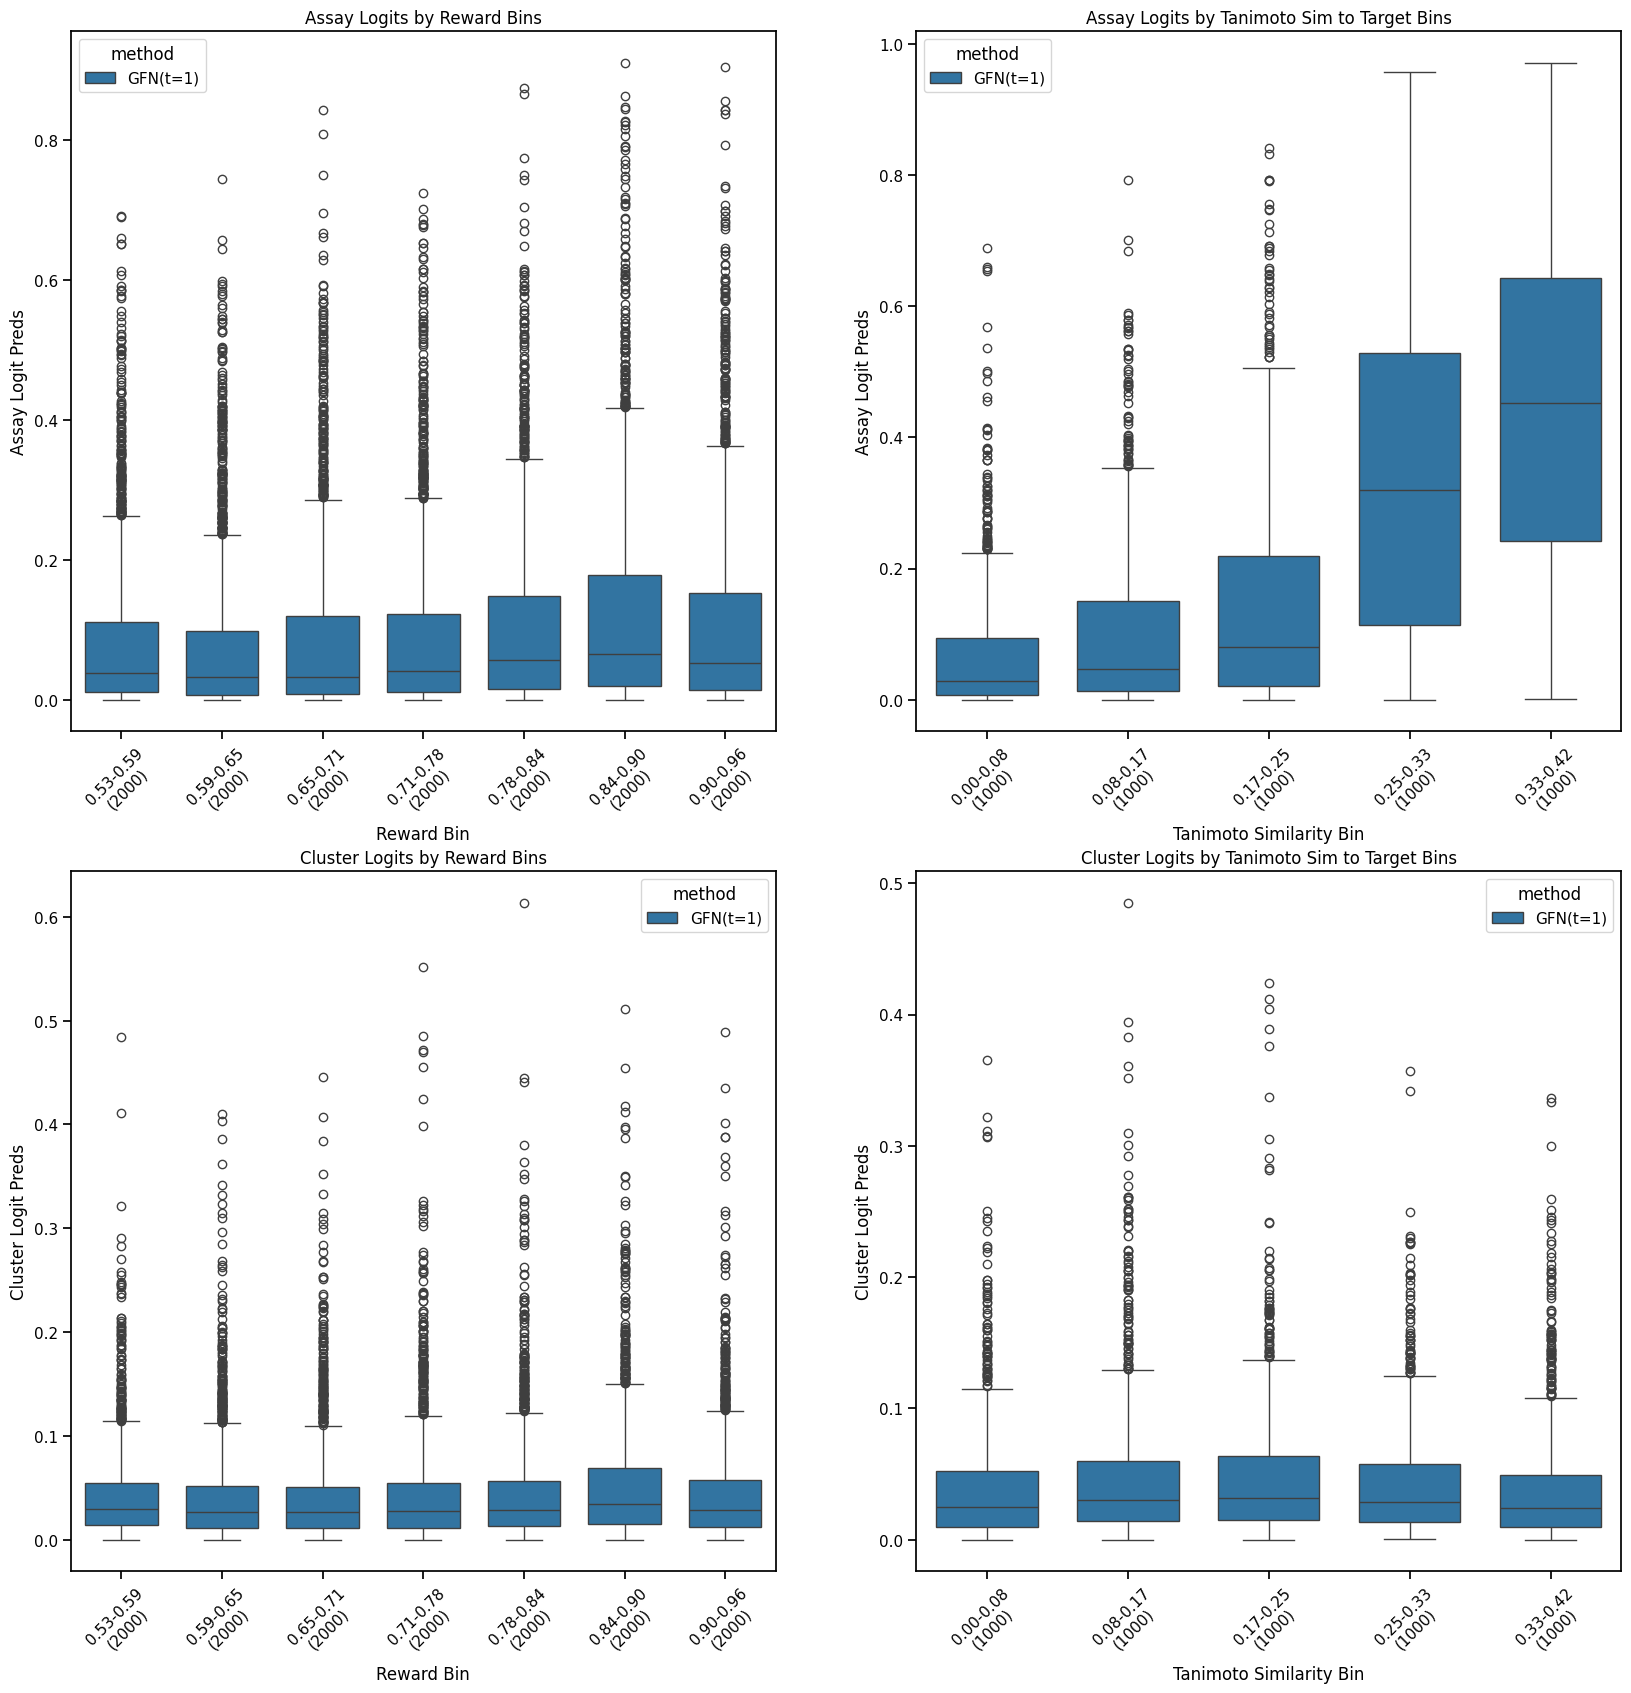

In [8]:
plot_unpooled_boxplot_oracle(runs_datum, bins1=10, bins2=10, n1=2000, n2=1000,
    assay_model=assay_model, assay_cols=target_active_assay_cols,
    cluster_model=cluster_model, cluster_id=target_cluster_id, use_gneprop=False,
    ignore=["PUMA_test"], save_path=f"{save_dir}/unpooled_boxplot_oracle.png")
plt.show()

  8%|▊         | 138/1697 [00:00<00:00, 74956.48it/s]


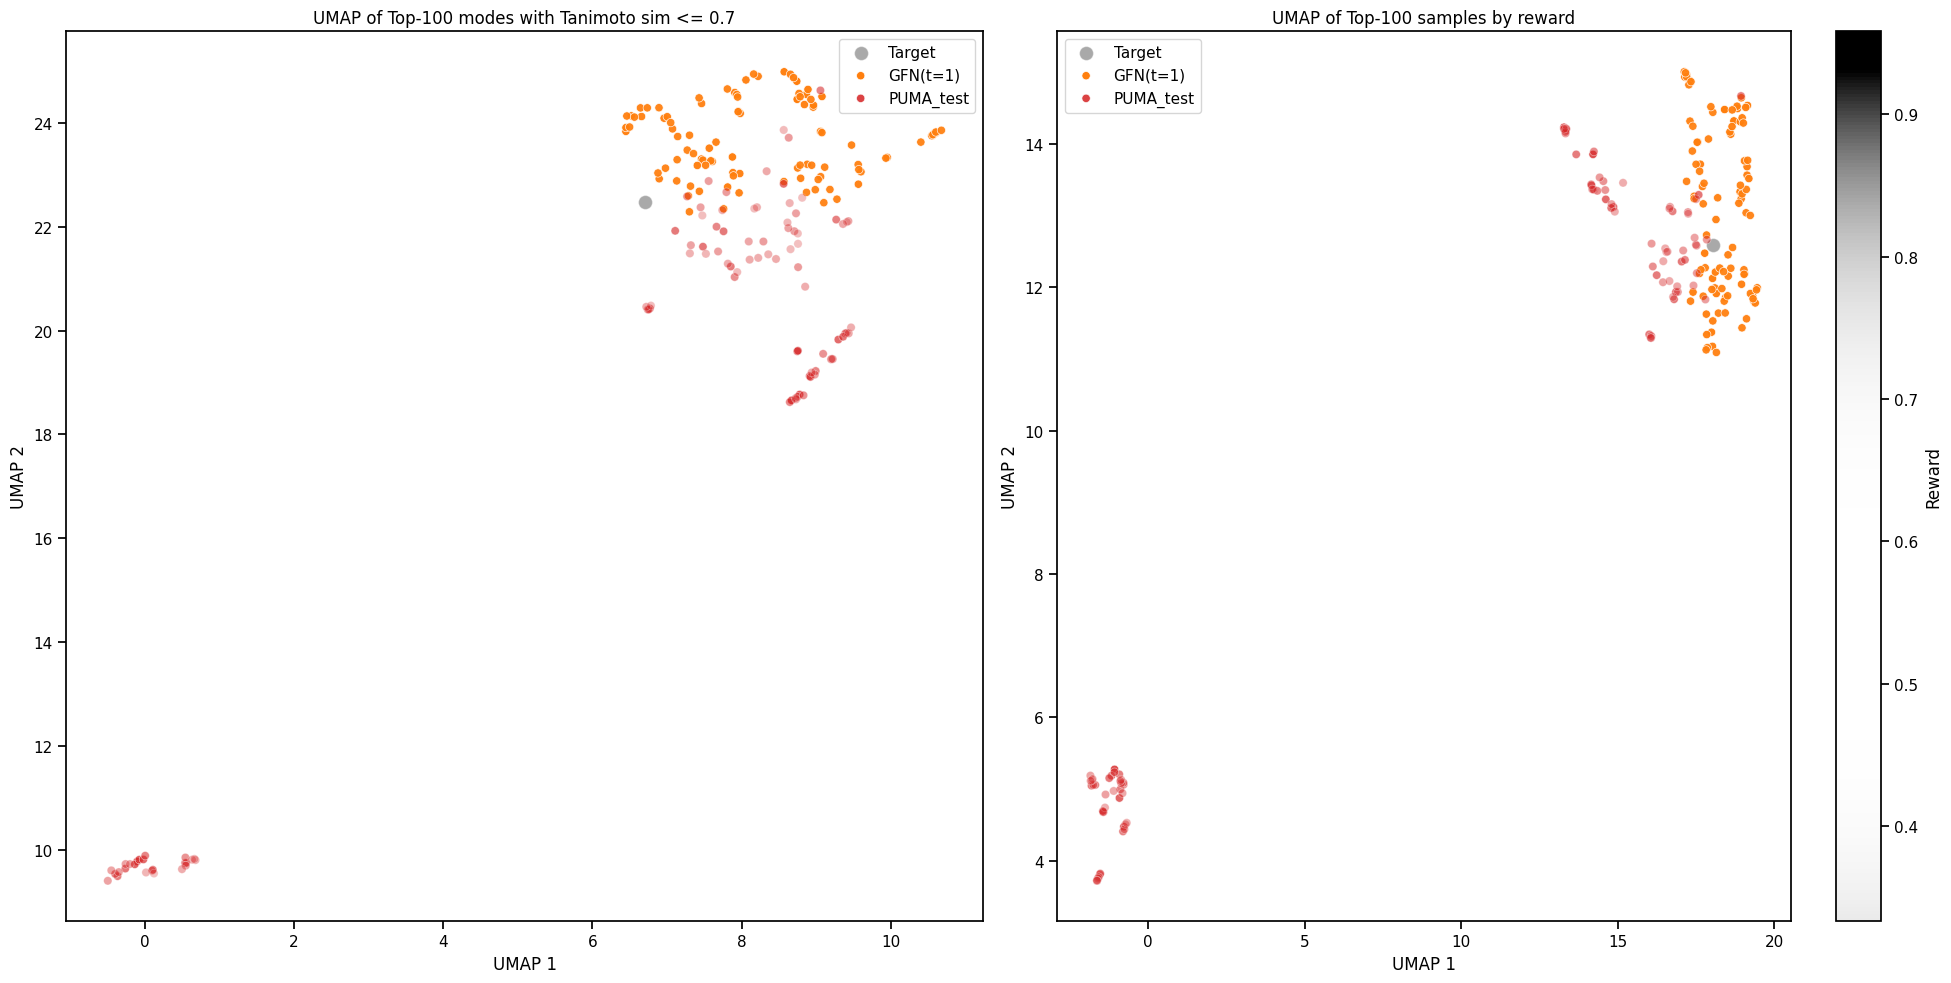

In [11]:
plot_umap_from_runs_datum(runs_datum, target_fp, target_reward, sim_thresh=0.7, n_neigh=15, k=MAX_K, 
                            ignore=["PUMA_test"], save_path=f"{save_dir}/umap_mols.png")
plt.show()